In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
!pip install impyute



You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
apartments = pd.read_csv('apartments_train.csv')
#print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
#describe_data(apartments, apartments_meta)
buildings = pd.read_csv('buildings_train.csv')
#print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
df = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
df.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
df.isnull().sum()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

<AxesSubplot:>

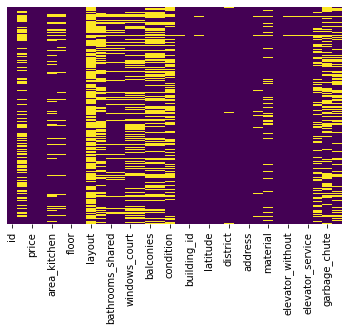

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
df.shape


(23285, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23285 non-null  int64  
 1   seller              14455 non-null  float64
 2   price               23285 non-null  float64
 3   area_total          23285 non-null  float64
 4   area_kitchen        18564 non-null  float64
 5   area_living         19403 non-null  float64
 6   floor               23285 non-null  float64
 7   rooms               23285 non-null  float64
 8   layout              5643 non-null   float64
 9   ceiling             12192 non-null  float64
 10  bathrooms_shared    19413 non-null  float64
 11  bathrooms_private   19413 non-null  float64
 12  windows_court       15213 non-null  float64
 13  windows_street      15213 non-null  float64
 14  balconies           12765 non-null  float64
 15  loggias             12765 non-null  float64
 16  cond

In [ ]:
# drop:['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)

def clean_data(data):
    nan_replacements = [
        # ('floor', 0), #no nans
        # ('rooms', 1), #no nans
        ('ceiling', data['ceiling'].mean()),
        #('bathrooms_shared',),
        #('bathrooms_private',),
        ('condition', 3),
        ('phones', 1),
        ('new', 0),
        #('contructed',),
        ('material', 2),
        ('elevator_without', 0),
        ('elevator_passenger', 1),
        ('elevator_service', 0),
        ('parking', 1),
        ('garbage_chute', 0),
        ('heating', 0),
        ('balconies', 0),
        ('loggias', 0),
        ('seller', 2),
        ('district', 2), #idk change
    ]

    for feature, value in nan_replacements:
        data[feature] = data[feature].fillna(value)

    return data

In [ ]:
df.isnull().sum()

#seller, layout, 

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

In [ ]:
df0 = df.drop(['street', 'address'], axis=1)
df0.columns

Index(['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude',
       'longitude', 'district', 'constructed', 'material', 'stories',
       'elevator_without', 'elevator_passenger', 'elevator_service', 'parking',
       'garbage_chute', 'heating'],
      dtype='object')

In [ ]:
import sys
#from impyute.imputation.cs import fast_knn
# 'seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'

sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
#imputed_training=fast_knn(df.values, k=30)
imputer = KNNImputer()
imputer.fit(df0)
dftrans = imputer.transform(df0)


In [ ]:
"""
df = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)

df.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)
df.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)
df.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)
df.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)
df.windows_court.fillna(df.windows_court.mode()[0], inplace = True)
df.windows_street.fillna(df.windows_street.mode()[0], inplace = True)
df.phones.fillna(df.phones.mode()[0], inplace=True)
df.new.fillna(df.new.mode()[0], inplace = True)
df.latitude.fillna(df.latitude.mean(), inplace = True)
df.longitude.fillna(df.longitude.mean(), inplace = True)
df.district.fillna(df.district.mode()[0], inplace = True)
df.constructed.fillna(df.constructed.mode()[0], inplace = True)
df.material.fillna(df.material.mode()[0], inplace = True)
df.elevator_without.fillna(df.elevator_without.mode()[0], inplace = True)
df.elevator_passenger.fillna(df.elevator_passenger.mode()[0], inplace = True)
df.elevator_service.fillna(df.elevator_service.mode()[0], inplace = True)
df.parking.fillna(df.parking.mode()[0], inplace = True)
df.shape
df.isnull().sum()
"""

"\ndf = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)\n\ndf.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)\ndf.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)\ndf.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)\ndf.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)\ndf.windows_court.fillna(df.windows_court.mode()[0], inplace = True)\ndf.windows_street.fillna(df.windows_street.mode()[0], inplace = True)\ndf.phones.fillna(df.phones.mode()[0], inplace=True)\ndf.new.fillna(df.new.mode()[0], inplace = True)\ndf.latitude.fillna(df.latitude.mean(), inplace = True)\ndf.longitude.fillna(df.longitude.mean(), inplace = True)\ndf.district.fillna(df.district.mode()[0], inplace = True)\ndf.constructed.fillna(df.constructed.mode()[0], inplace = True)\ndf.material.fillna(df.material.mode()[0], inplace = True)\ndf.elevator_without.fillna(df.elevator

In [ ]:
"""df.elevator_without = df.elevator_without.astype(int)
df.floor = df.floor.astype(int)
df.rooms = df.rooms.astype(int)
df.bathrooms_shared = df.bathrooms_shared.astype(int)
df.bathrooms_private = df.bathrooms_private.astype(int)
df.windows_court = df.windows_court.astype(int)
df.windows_street = df.windows_street.astype(int)
df.phones = df.phones.astype(int)
df.new = df.new.astype(int)
df.district = df.district.astype(int)
df.constructed = df.constructed.astype(int)
df.material = df.material.astype(int)
df.stories = df.stories.astype(int)
df.elevator_without = df.elevator_without.astype(int)
df.elevator_passenger = df.elevator_passenger.astype(int)
df.elevator_service = df.elevator_service.astype(int)
df.parking = df.parking.astype(int)
"""

'df.elevator_without = df.elevator_without.astype(int)\ndf.floor = df.floor.astype(int)\ndf.rooms = df.rooms.astype(int)\ndf.bathrooms_shared = df.bathrooms_shared.astype(int)\ndf.bathrooms_private = df.bathrooms_private.astype(int)\ndf.windows_court = df.windows_court.astype(int)\ndf.windows_street = df.windows_street.astype(int)\ndf.phones = df.phones.astype(int)\ndf.new = df.new.astype(int)\ndf.district = df.district.astype(int)\ndf.constructed = df.constructed.astype(int)\ndf.material = df.material.astype(int)\ndf.stories = df.stories.astype(int)\ndf.elevator_without = df.elevator_without.astype(int)\ndf.elevator_passenger = df.elevator_passenger.astype(int)\ndf.elevator_service = df.elevator_service.astype(int)\ndf.parking = df.parking.astype(int)\n'

In [ ]:
df1 = pd.DataFrame(dftrans, columns=list(df0.columns.values))

In [ ]:
"""df1.elevator_without = df1.elevator_without.astype(int)
df1.floor = df1.floor.astype(int)
df1.rooms = df1.rooms.astype(int)
df1.bathrooms_shared = df1.bathrooms_shared.astype(int)
df1.bathrooms_private = df1.bathrooms_private.astype(int)
df1.windows_court = df1.windows_court.astype(int)
df1.windows_street = df1.windows_street.astype(int)
df1.phones = df1.phones.astype(int)
df1.new = df1.new.astype(int)
df1.district = df1.district.astype(int)
df1.constructed = df1.constructed.astype(int)
df1.material = df1.material.astype(int)
df1.stories = df1.stories.astype(int)
df1.elevator_without = df1.elevator_without.astype(int)
df1.elevator_passenger = df1.elevator_passenger.astype(int)
df1.elevator_service = df1.elevator_service.astype(int)
df1.parking = df1.parking.astype(int)
df1.garbage_chute = df1.garbage_chute.astype(int)
df1.heating = df1.heating.astype(int)
df1.building_id = df1.building_id.astype(int)
df1.condition = df1.condition.astype(int)
df1.loggias = df1.loggias.astype(int)
df1.balconies = df1.balconies.astype(int)
#df1.ceiling = df1.ceiling.round(0)
#df1.ceiling = df1.ceiling.astype(int)"""




'df1.elevator_without = df1.elevator_without.astype(int)\ndf1.floor = df1.floor.astype(int)\ndf1.rooms = df1.rooms.astype(int)\ndf1.bathrooms_shared = df1.bathrooms_shared.astype(int)\ndf1.bathrooms_private = df1.bathrooms_private.astype(int)\ndf1.windows_court = df1.windows_court.astype(int)\ndf1.windows_street = df1.windows_street.astype(int)\ndf1.phones = df1.phones.astype(int)\ndf1.new = df1.new.astype(int)\ndf1.district = df1.district.astype(int)\ndf1.constructed = df1.constructed.astype(int)\ndf1.material = df1.material.astype(int)\ndf1.stories = df1.stories.astype(int)\ndf1.elevator_without = df1.elevator_without.astype(int)\ndf1.elevator_passenger = df1.elevator_passenger.astype(int)\ndf1.elevator_service = df1.elevator_service.astype(int)\ndf1.parking = df1.parking.astype(int)\ndf1.garbage_chute = df1.garbage_chute.astype(int)\ndf1.heating = df1.heating.astype(int)\ndf1.building_id = df1.building_id.astype(int)\ndf1.condition = df1.condition.astype(int)\ndf1.loggias = df1.logg

In [ ]:
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0.0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.6,2.650,...,11.0,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,1.0,0.4
1,1.0,0.4,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,2.744,...,2.0,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0
2,2.0,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,0.8,2.650,...,6.0,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,0.2,0.4
3,3.0,0.4,10500000.0,88.0,14.0,48.0,18.0,3.0,1.0,2.744,...,2.0,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0
4,4.0,1.4,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.900,...,11.0,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
#names = list(df0.columns.values)
print(names)
#names.remove('street')
#print(names)
#list1 = [21, 20, 5, 4, 3, 2, 0]
names = ['seller', 'floor', 'rooms', 'layout', 'ceiling', 
'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 
'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 
'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']

#for l in list1:
#    names.pop(l)
print(names)

['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
['seller', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']


In [ ]:
for x in names:
    df1[x] = df1[x].round(decimals = 0)
    df1[x] = df1[x].astype(int)

In [ ]:

df1['id'] = df1['id'].astype(int)
df1['street'] = df.street
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,2021,3,9,0,1,1,1,1,0,Бунинские Луга ЖК
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,2021,3,15,0,1,1,1,0,0,Саларьево Парк ЖК
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2017,2,15,0,1,1,1,0,0,улица Сервантеса


In [ ]:
df1.to_csv('Training_clean3.csv', index=False)
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,2021,3,9,0,1,1,1,1,0,Бунинские Луга ЖК
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,2021,3,15,0,1,1,1,0,0,Саларьево Парк ЖК
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2017,2,15,0,1,1,1,0,0,улица Сервантеса


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99c1e030-46bc-40fa-835c-0661eae0d488' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>